# False Positive Brand Classifier - EDA & Feature Engineering

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The system:

1. **Collects news articles daily** from NewsData.io and GDELT APIs using brand-specific keyword queries
2. **Filters false positives** using this classifier (e.g., "Puma" the animal vs Puma sportswear)
3. **Classifies ESG content** using a pre-filter classifier to identify articles with sustainability relevance
4. **Labels articles** with specific ESG categories using Claude LLM:
   - **Environmental**: Carbon emissions, waste management, sustainable materials
   - **Social**: Worker rights, diversity & inclusion, community engagement
   - **Governance**: Ethical sourcing, transparency, board structure
   - **Digital Transformation**: Technology innovation, digital initiatives

**Pipeline Position:** Data Collection → **FP Filter (this classifier)** → EP Filter → LLM Labeling

This FP classifier is the **first filter in the pipeline**, reducing LLM API costs by removing articles that don't actually discuss the sportswear brands we're tracking.

---

## Target Brands (50)

| | | | | |
|-------|-------|-------|-------|-------|
| Nike | Adidas | Puma | Under Armour | Lululemon |
| Patagonia | Columbia Sportswear | New Balance | ASICS | Reebok |
| Skechers | Fila | The North Face | Vans | Converse |
| Salomon | Mammut | Umbro | Anta | Li-Ning |
| Brooks Running | Decathlon | Deckers | Yonex | Mizuno |
| K-Swiss | Altra Running | Hoka | Saucony | Merrell |
| Timberland | Spyder | On Running | Allbirds | Gymshark |
| Everlast | Arc'teryx | Jack Wolfskin | Athleta | Vuori |
| Cotopaxi | Prana | Eddie Bauer | 361 Degrees | Xtep |
| Peak Sport | Mountain Hardwear | Black Diamond | Outdoor Voices | Diadora |

See `src/data_collection/config.py` for the authoritative brand list.

---

## Notebook Objective

Develop a feature engineering pipeline that distinguishes articles genuinely discussing sportswear brands from **false positives**. False positives include:

1. **Brand name conflicts** - "Puma" the animal, "Patagonia" the region, "Black Diamond" the power company
2. **Tangential mentions** - Articles about other companies that briefly mention a sportswear brand

See the [False Positive Definition](#false-positive-definition) section for detailed examples.

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - downstream LLM can catch it

We optimize for **F2 score** which weights recall 2x higher than precision.

---

## Technical Approach

### Data Split Strategy
| Split | Percentage | Purpose |
|-------|------------|---------|
| Training | 60% | Fit feature transformers, train classifiers |
| Validation | 20% | Feature engineering comparison via CV |
| Test | 20% | Reserved for fp3 final evaluation |

### Feature Engineering Methods Compared

#### TF-IDF + LSA Methods
| Method | Description | Features |
|--------|-------------|----------|
| `tfidf_lsa_ner_proximity` | TF-IDF + LSA + NER + proximity to sportswear vocabulary | ~143 |
| `tfidf_lsa_ner_proximity_brands` | + Brand-specific context features (frequency, position) | ~193 |

#### Doc2Vec Methods
| Method | Description | Features |
|--------|-------------|----------|
| `doc2vec_ner_brands` | Gensim Doc2Vec embeddings + NER + brand indicator features | ~164 |

### Key Feature Types
- **Semantic features**: TF-IDF term patterns + LSA dimensionality reduction; Doc2Vec for dense document embeddings
- **NER features**: spaCy entity counts (ORG, GPE, PERSON, PRODUCT) to distinguish company news from geographic/biographical content
- **Proximity features**: Distance between brand mentions and sportswear vocabulary (e.g., "running", "athletic", "sneaker")
- **Brand context features**: Brand mention frequency, position (title vs body), co-occurrence with sportswear terms

See the [Feature Extraction Methods Reference](#feature-extraction-methods-reference) for detailed documentation of all feature types.

### Evaluation Methodology
- **Cross-validation**: 3-fold stratified CV on train+val combined (80% of data)
- **Primary Metric**: F2 score (weights recall 2x over precision)
- **Baseline Classifiers**: Logistic Regression, Random Forest, HistGradientBoosting
- **Hyperparameter Tuning**: Grid search over key transformer parameters (e.g., LSA components, Doc2Vec vector size)

### Artifacts Produced
| Artifact | Description |
|----------|-------------|
| `fp_feature_transformer.joblib` | Fitted feature transformer for fp2/fp3 |
| `fp_feature_config.json` | Transformer configuration for reproducibility |
| `fp_fe_comparison.json` | Cross-validation results for all methods |

---

## Contents

1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis-all-data) - Class distribution before splitting
4. [Data Preprocessing & Split](#3-data-preprocessing--trainvaltest-split) - Text cleaning and stratified split
5. [Exploratory Data Analysis](#4-exploratory-data-analysis-training-data-only) - Text length, brand distribution, word frequencies
6. [Feature Engineering Comparison](#5-feature-engineering-comparison) - Cross-validation comparison of methods
   - [Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning) - Tune best method's parameters
7. [Pipeline Export](#6-pipeline-export) - Save transformer for model selection notebook
8. [Summary](#7-summary)

**Reference Sections:**
- [False Positive Definition](#false-positive-definition) - Types of false positives and examples
- [Feature Extraction Methods Reference](#feature-extraction-methods-reference) - Detailed NLP method documentation

## False Positive Definition

A "false positive" in this context means an article that was captured by our data collection pipeline (because it mentions a sportswear brand name) but should NOT be labeled with ESG categories. There are two distinct types:

### 1. Brand Name Conflicts
The brand name in the article refers to something other than the sportswear company:
- **Puma** → the animal (wildcat/cougar), Ford Puma (car), or Puma Exploration (mining company)
- **Patagonia** → the geographic region in South America
- **Columbia** → the country, Columbia River, Columbia University, or Columbia Pictures
- **North Face** → geographic term for the north side of a mountain
- **Black Diamond** → Black Diamond Corporation (power company) or Black Diamond Therapeutics
- **Vans** → vehicles (delivery vans, camper vans, electric van fleets)
- **Anta** → political district in India, or Antalpha Platform (NASDAQ: ANTA - financial company)
- **Decathlon** → Decathlon Capital Partners (venture capital firm)

### 2. Tangential Brand Mentions
The brand name correctly refers to the sportswear company, but the article is not primarily ABOUT that brand:
- **Biographical mentions** - "Former Nike VP joins Battery Company as CEO" (article is about the battery company, not Nike)
- **Incidental references** - Articles about other companies that briefly mention a sportswear brand for comparison
- **Historical context** - News about acquisitions where the brand is mentioned only as background

**Key Test:** Is this article primarily about the sportswear brand's current activities, products, or ESG initiatives? If the brand is only mentioned as background context, historical reference, or biographical detail, it's a false positive.

## Feature Extraction Methods Reference

This section documents all text feature extraction methods implemented in `FPFeatureTransformer`. These NLP techniques were not covered in the ML Zoomcamp curriculum.

---

### Base Text Representation Methods

#### TF-IDF (Term Frequency-Inverse Document Frequency)
Converts text to sparse numerical vectors by weighting terms based on their frequency in a document vs. corpus-wide rarity.
- **How it works**: For each term, `TF(t,d) × IDF(t)` where TF measures term frequency in document d and IDF penalizes common terms
- **Parameters**: `max_features` (vocabulary size), `ngram_range` (word combinations), `sublinear_tf` (log scaling)
- **Output**: Sparse matrix of shape `(n_docs, max_features)`
- **Strengths**: Fast, interpretable, captures domain vocabulary
- **Limitations**: No semantic understanding, high dimensionality

#### LSA (Latent Semantic Analysis)
Dimensionality reduction via truncated SVD applied to TF-IDF matrices, capturing latent semantic topics.
- **How it works**: Decomposes TF-IDF matrix into `U × Σ × V^T`, keeping top-k singular values
- **Parameters**: `lsa_n_components` (number of latent dimensions, typically 50-150)
- **Output**: Dense matrix of shape `(n_docs, n_components)`
- **Strengths**: Captures semantic similarity, reduces noise, dense representation
- **Limitations**: Linear method, loses some fine-grained distinctions

#### Doc2Vec (Paragraph Vectors)
Neural network-based document embeddings using Gensim's implementation.
- **How it works**: Trains a shallow neural network to predict words given document ID + context
- **Parameters**: `doc2vec_vector_size` (embedding dimension), `doc2vec_epochs`, `doc2vec_dm` (0=DBOW, 1=DM)
- **Output**: Dense matrix of shape `(n_docs, vector_size)`
- **Strengths**: Captures semantic similarity, handles variable-length docs
- **Limitations**: Requires training, less interpretable

#### Sentence Transformers (all-MiniLM-L6-v2)
Pre-trained transformer model fine-tuned for semantic similarity (from HuggingFace).
- **How it works**: Passes text through BERT-like encoder, pools token embeddings to sentence vector
- **Parameters**: `sentence_model_name` (model identifier)
- **Output**: Dense matrix of shape `(n_docs, 384)` for MiniLM
- **Strengths**: State-of-the-art semantic understanding, zero-shot transfer
- **Limitations**: Large model size (~90MB), slower inference
- **Note**: Commented out in this project due to model size constraints for GitHub

---

### Domain-Specific Feature Types

#### NER Features (Named Entity Recognition)
Counts of spaCy-detected entity types to distinguish article contexts.
- **Entity types tracked**: `ORG` (organizations), `GPE` (geopolitical entities), `PERSON`, `PRODUCT`, `DATE`, `MONEY`
- **Why it helps**: Geographic articles have high GPE counts; company news has high ORG counts; biographical pieces have high PERSON counts
- **Output**: 6 features (one per entity type), scaled via StandardScaler

#### Brand-Specific NER Features
Entity patterns specifically around brand mentions to detect false positive contexts.
- **Features**:
  - `brand_near_gpe`: GPE entity within 50 chars of brand mention (suggests geographic context)
  - `brand_near_person`: PERSON entity near brand (suggests biographical/person name)
  - `brand_near_org`: ORG entity near brand (suggests company context)
  - `brand_in_lowercase`: Brand mentioned in lowercase (e.g., "vans" for vehicles)
  - `has_person_name_brand`: Brand matches person name patterns (Salomon, Jordan, Brooks)
  - `has_geographic_brand`: Brand matches geographic entities (Patagonia, Columbia)
  - `salomon_person_context`: Specific detection for "Salomon" as surname
  - `jordan_person_context`: Specific detection for "Jordan" as person name
- **Output**: 8 features, scaled via StandardScaler

#### Proximity Features
Measures distance between brand mentions and sportswear/non-sportswear vocabulary.
- **Vocabularies**:
  - `SPORTSWEAR_VOCAB`: ["running", "athletic", "sneaker", "shoe", "footwear", "apparel", ...]
  - `NON_SPORTSWEAR_VOCAB`: ["mining", "exploration", "wildlife", "university", "vehicle", ...]
- **Features computed**:
  - `min_sportswear_distance`: Minimum word distance to sportswear vocabulary
  - `min_non_sportswear_distance`: Minimum word distance to non-sportswear vocabulary
  - `sportswear_proximity_score`: Normalized proximity to sportswear terms
  - `context_polarity`: Difference between sportswear and non-sportswear proximity
- **Parameters**: `proximity_window_size` (words to search around brand)
- **Output**: 4 features, scaled via StandardScaler

#### Negative Context Features
Detects vocabulary that strongly suggests non-sportswear content.
- **Categories**:
  - Mining/geology: "lithium", "exploration", "ore", "deposit"
  - Wildlife: "animal", "wildlife", "habitat", "species"
  - Automotive: "vehicle", "car", "motor", "driving"
  - Financial-only: "ticker", "nasdaq", "trading volume"
- **Output**: 4 features (one per category), scaled via StandardScaler

#### FP Indicator Features
Binary flags and scores detecting specific false positive patterns.
- **Pattern detectors**:
  - `has_stock_ticker`: Matches patterns like "NASDAQ:ANTA", "TSE:BDI"
  - `has_company_suffix`: Matches "LLC", "Ltd", "Corp" with brand names
  - `has_vehicle_pattern`: Matches "Ford Puma", "delivery vans"
  - `has_animal_context`: Animal keywords near "Puma" brand
  - `has_geographic_context`: Geographic terms near "Patagonia" brand
  - `has_person_name`: Person name patterns (Manor Salomon, Michael Jordan)
  - `has_financial_jargon`: Stock article patterns (moving average, short interest, OTCMKTS)
  - `has_institution`: University, resort, hospital patterns
  - `has_phrase_not_brand`: "new balance of power", "on running" (as phrase)
  - `has_product_disambiguation`: "Black Diamond Cheese", "AI ASICs" (chips)
  - `has_sponsored_event`: Under Armour All-America, Nike Bowl (NEGATIVE FP indicator)
- **Aggregate features**: `fp_indicator_count`, `fp_indicator_score` (weighted sum)
- **Output**: 13 features, scaled via StandardScaler

#### Brand Indicator Features
Multi-hot encoding of which brands are mentioned in the article.
- **How it works**: Binary vector indicating presence of each of 50 tracked brands
- **Output**: 50 features (one per brand)
- **Why it helps**: Some brands have higher FP rates (Puma, Patagonia, Vans)

#### Brand Summary Features
Aggregate statistics about brand mentions.
- **Features**:
  - `n_brands_mentioned`: Count of unique brands in article
  - `brand_in_title`: Binary flag if brand appears in title
  - `brand_mention_count`: Total brand mentions in article
- **Output**: 3 features, scaled via StandardScaler

---

### Combined Method Configurations

| Method | Components | Total Features |
|--------|------------|----------------|
| `tfidf_lsa_ner_proximity` | LSA + NER + Brand NER + Proximity + Negative Context + FP Indicators | ~143 |
| `tfidf_lsa_ner_proximity_brands` | Above + Brand Indicators + Brand Summary | ~196 |
| `doc2vec_ner_brands` | Doc2Vec + NER + Brand NER + Brand Indicators | ~172 |
| `sentence_transformer_ner` | Sentence embeddings + NER + Brand NER | ~406 |

---

### Implementation Details

All feature methods are implemented in `src/fp1_nb/feature_transformer.py`:
- `FPFeatureTransformer`: Main class with `fit()`, `transform()`, `fit_transform()` methods
- Implements scikit-learn Transformer interface for pipeline compatibility
- Includes `save_config()` and `load_config()` for reproducibility

See the class docstrings for complete parameter documentation.

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    analyze_tuning_results,
    evaluate_feature_engineering,
    plot_fe_comparison,
    plot_tuning_results,
    run_transformer_tuning,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 1,535 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 11.14 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],wwd.com,[],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],complex.com,[],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],mlive.com,[],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],abc7news.com,[],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535 entries, 0 to 1534
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     1535 non-null   object
 1   title          1535 non-null   object
 2   content        1535 non-null   object
 3   brands         1535 non-null   object
 4   source_name    1535 non-null   object
 5   category       1535 non-null   object
 6   is_sportswear  1535 non-null   int64 
 7   source         1535 non-null   object
 8   fp_reason      306 non-null    object
dtypes: int64(1), object(8)
memory usage: 108.1+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id          0
title               0
content             0
brands              0
source_name         0
category            0
is_sportswear       0
source              0
fp_reason        1229
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           647
skipped           564
false_positive    324
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 1,535

Class distribution:
  Not Sportswear (FP): 324 (21.1%)
  Sportswear: 1,211 (78.9%)

Imbalance ratio: 3.74:1

[OK] Dataset is reasonably balanced
Figure saved to images/fp_target_distribution.png


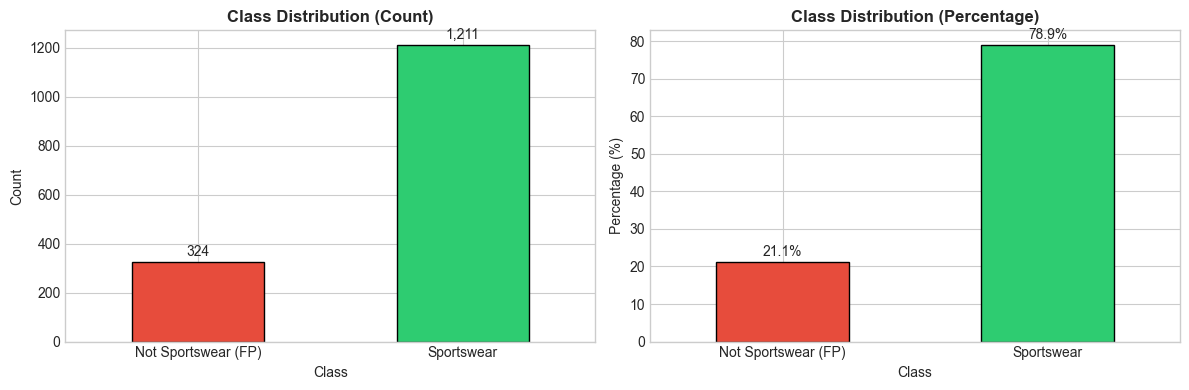

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, content, and metadata (source, category) into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL].values

X_val = val_df['text_features']
y_val = val_df[TARGET_COL].values

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

# Combine train+val for feature engineering comparison and tuning
# CV will create its own internal train/val splits, so we use 80% of data
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = np.concatenate([y_train, y_val])
trainval_source_names = train_source_names + val_source_names
trainval_categories = train_categories + val_categories

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Train+Val (for CV): {len(X_trainval)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,535

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      921 (60.0%)
  Validation: 307 (20.0%)
  Test:       307 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 78.9%, 0: 21.1%
  Val: 1: 78.8%, 0: 21.2%
  Test: 1: 78.8%, 0: 21.2%

Dataset sizes:
  Train: 921 samples
  Val:   307 samples
  Train+Val (for CV): 1228 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 921

Overall statistics:
  Character length: mean=3746, median=2640, range=[122, 52607]
  Word count: mean=602, median=421, range=[22, 8901]

By is_sportswear:
  Class 0:
    Chars: mean=4581, median=3044
    Words: mean=721, median=484
  Class 1:
    Chars: mean=3524, median=2511
    Words: mean=570, median=406


Figure saved to images/fp_text_length_dist.png


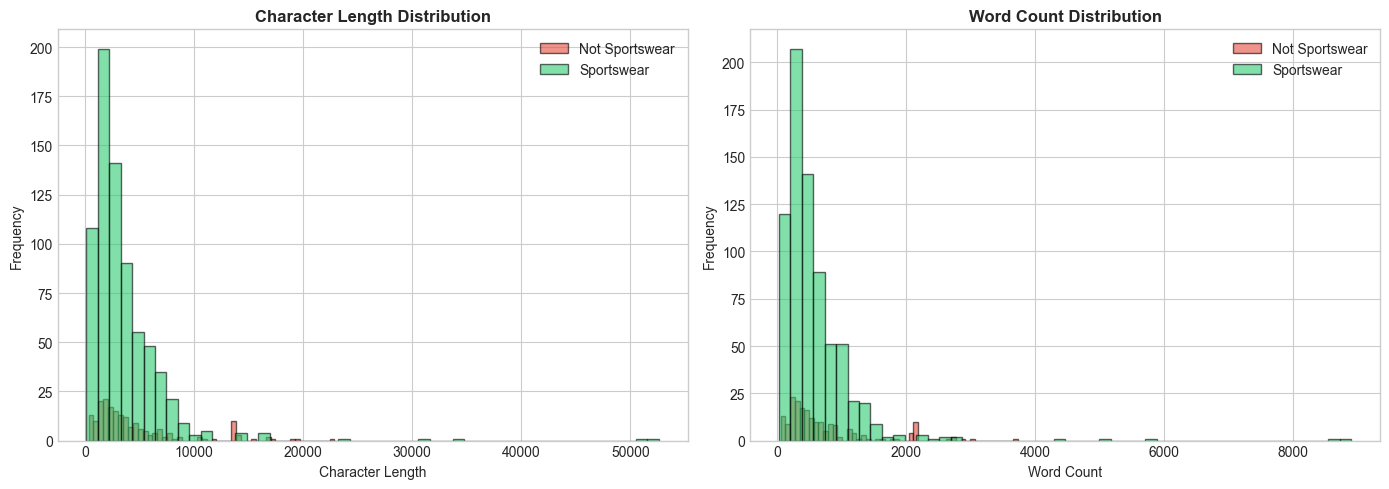

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 992
Unique brands: 42

Top 15 brands:
  Nike: 255 (25.7%)
  Lululemon: 105 (10.6%)
  Adidas: 73 (7.4%)
  Puma: 62 (6.2%)
  Hoka: 39 (3.9%)
  Anta: 36 (3.6%)
  Vans: 36 (3.6%)
  Patagonia: 35 (3.5%)
  Under Armour: 30 (3.0%)
  New Balance: 29 (2.9%)
  Black Diamond: 28 (2.8%)
  Skechers: 24 (2.4%)
  ASICS: 23 (2.3%)
  Converse: 21 (2.1%)
  Timberland: 20 (2.0%)

Brand distribution by is_sportswear:
  Class 0: 194 mentions, top: Black Diamond (28), Vans (27), Anta (26)
  Class 1: 798 mentions, top: Nike (246), Lululemon (103), Adidas (72)


Figure saved to images/fp_brand_dist.png


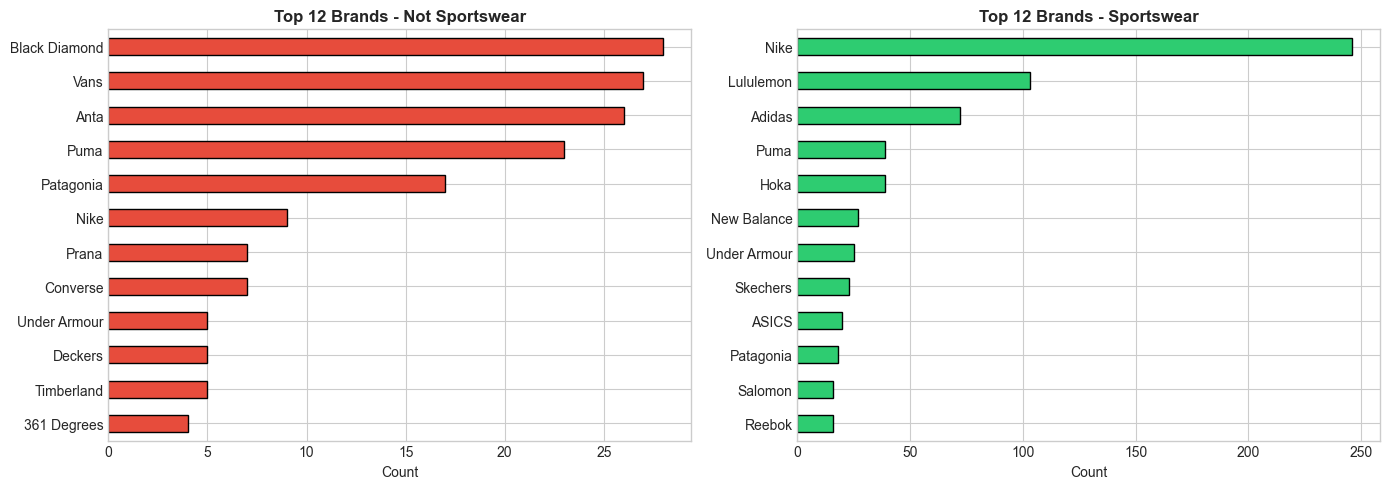

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 731
  stock: 402
  energy: 292
  report: 279
  shares: 279
  year: 266
  puma: 243
  free: 235
  investment: 232
  over: 228
  next: 217
  technology: 214
  get: 211
  month: 209
  out: 207

Top 15 words for class_1:
  nike: 2,237
  company: 1,552
  year: 1,230
  brand: 1,116
  shares: 1,036
  stock: 1,003
  lululemon: 957
  quarter: 833
  price: 762
  like: 745
  out: 731
  running: 707
  market: 688
  over: 642
  shoe: 587


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Anta']
Title: Republicans Could Seize Advantage In California Governor's Race If Too Many Democrats Run...
Reason: No ESG content found
----------------------------------------

Brands: ['Spyder']
Title: Chevrolet Corvair Monza Spyder : The First Car with a Turbocharged Flat - Six Engine...
Reason: Spyder: Article is about the Chevrolet Corvair Monza Spyder, which is a car model/trim package from the 1960s, not Spyder sportswear/ski apparel brand
----------------------------------------

Brands: ['On Running']
Title: Texans Aim to Keep Strong Focus on Running the Ball...
Reason: On Running: The phrase 'On Running' in this article refers to the Houston Texans' focus on their running game strategy in football, not the Swiss sportswear company On Running
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the combined training+validation data (80% of total). Since cross-validation creates its own internal train/val splits, using the full train+val set provides more data for reliable hyperparameter selection while keeping the test set completely held out.

We benchmark with three classifiers: Logistic Regression, Random Forest, and HistGradientBoosting. This helps us select the best feature engineering approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
# Each config includes transformer parameters and optional tuning configuration
fe_configs = {
    # 'tfidf_word': {
    #     'method': 'tfidf_word',
    #     'max_features': 10000,
    #     'ngram_range': (1, 2),
    #     'sublinear_tf': True,
    #     'tuning': {
    #         'param_name': 'max_features',
    #         'param_values': [5000, 6000, 8000, 10000, 12000, 15000],
    #         'description': 'TF-IDF vocabulary size'
    #     }
    # },
    # 'tfidf_lsa': {
    #     'method': 'tfidf_lsa',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'tuning': {
    #         'param_name': 'lsa_n_components',
    #         'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300],
    #         'description': 'LSA dimensionality'
    #     }
    # },
    # 'tfidf_lsa_ner': {
    #     'method': 'tfidf_lsa_ner',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'proximity_window_size': 15,
    #     'tuning': {
    #         'param_name': 'lsa_n_components',
    #         'param_values': [50, 60, 80, 100, 120, 150, 200],
    #         'description': 'LSA dimensionality (with NER)'
    #     }
    # },
    # 'tfidf_lsa_proximity': {
    #     'method': 'tfidf_lsa_proximity',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'proximity_window_size': 15,
    #     'tuning': {
    #         'param_name': 'lsa_n_components',
    #         'param_values': [50, 60, 80, 100, 120, 150, 200],
    #         'description': 'LSA dimensionality (with proximity features)'
    #     }
    # },
    # 'tfidf_lsa_ner_proximity': {
    #     'method': 'tfidf_lsa_ner_proximity',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'proximity_window_size': 15,
    #     'tuning': {
    #         'param_name': 'lsa_n_components',
    #         'param_values': [70, 80, 90, 100, 120, 150, 200, 250, 300],
    #         'description': 'LSA dimensionality (with NER + proximity)'
    #     }
    # },
    'tfidf_lsa_ner_proximity_brands': {
        'method': 'tfidf_lsa_ner_proximity_brands',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'tuning': {
            'param_name': 'lsa_n_components',
            'param_values': [70, 80, 90, 100, 120, 150, 200, 250, 300],
            'description': 'LSA dimensionality (with NER + proximity + brands)'
        }
    },
    'doc2vec_ner_brands': {
        'method': 'doc2vec_ner_brands',
        'doc2vec_vector_size': 100,
        'doc2vec_min_count': 2,
        'doc2vec_epochs': 40,
        'doc2vec_dm': 1,
        'tuning': {
            'param_name': 'doc2vec_vector_size',
            'param_values': [70, 80, 90, 100, 120, 150, 200, 250],
            'description': 'Doc2Vec embedding dimension'
        }
    },
    # NOTE: sentence_transformer methods commented out - model size too large for GitHub (105MB)
    # Performance is only occasionally better than tfidf_lsa methods, and not by much
    # 'sentence_transformer_ner': {
    #     'method': 'sentence_transformer_ner',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    #     'tuning': {
    #         'param_name': 'proximity_window_size',
    #         'param_values': [10, 15, 20, 25, 30],
    #         'description': 'NER proximity window size'
    #     }
    # },
    # 'sentence_transformer_ner_brands': {
    #     'method': 'sentence_transformer_ner_brands',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    #     'tuning': {
    #         'param_name': 'proximity_window_size',
    #         'param_values': [10, 15, 20, 25, 30],
    #         'description': 'NER proximity window size (with brands)'
    #     }
    # }
}

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'requires_dense': False,  # RF handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")
    if 'tuning' in config:
        tuning = config['tuning']
        print(f"    └─ Tuning: {tuning['param_name']} = {tuning['param_values']}")

Feature Engineering Approaches to Compare:
  tfidf_lsa_ner_proximity_brands: tfidf_lsa_ner_proximity_brands
    └─ Tuning: lsa_n_components = [70, 80, 90, 100, 120, 150, 200, 250, 300]
  doc2vec_ner_brands: doc2vec_ner_brands
    └─ Tuning: doc2vec_vector_size = [70, 80, 90, 100, 120, 150, 200, 250]


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Transformer is fitted on TRAINING data only (to prevent data leakage)
# CV is performed on TRAIN+VAL combined (CV creates internal splits)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Run feature engineering evaluation
fe_results = evaluate_feature_engineering(
    fe_configs=fe_configs,
    classifiers=classifiers,
    transformer_class=FPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    train_source_names=train_source_names,
    train_categories=train_categories,
    trainval_source_names=trainval_source_names,
    trainval_categories=trainval_categories,
    random_state=RANDOM_STATE,
)

Evaluating tfidf_lsa_ner_proximity_brands...
  Feature shape: (1228, 193), sparse: False
  [LogisticRegression] CV F2: 0.9715 (+/- 0.0018)
  [RandomForest] CV F2: 0.9850 (+/- 0.0060)
  [HistGradientBoosting] CV F2: 0.9810 (+/- 0.0059)
Evaluating doc2vec_ner_brands...
  Feature shape: (1228, 172), sparse: False
  [LogisticRegression] CV F2: 0.9578 (+/- 0.0124)
  [RandomForest] CV F2: 0.9772 (+/- 0.0029)
  [HistGradientBoosting] CV F2: 0.9694 (+/- 0.0048)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_lsa_ner_proximity_brands         193  0.971534   0.001763   0.972136   
doc2vec_ner_brands                     172  0.957820   0.012359   0.956656   

                                cv_precision  
name                                          
tfidf_lsa_ner_proximity_brands      0.969166  
doc2vec_ner_brands                  0.962568  

RandomForest Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_lsa_ner_proximity_brands         193  0.985016   0.005966   0.990712   
doc2vec_ner_brands                     172  0.977167   0.002869   0.997936   

                                cv_precision  
name                                          


Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fe_comparison.png


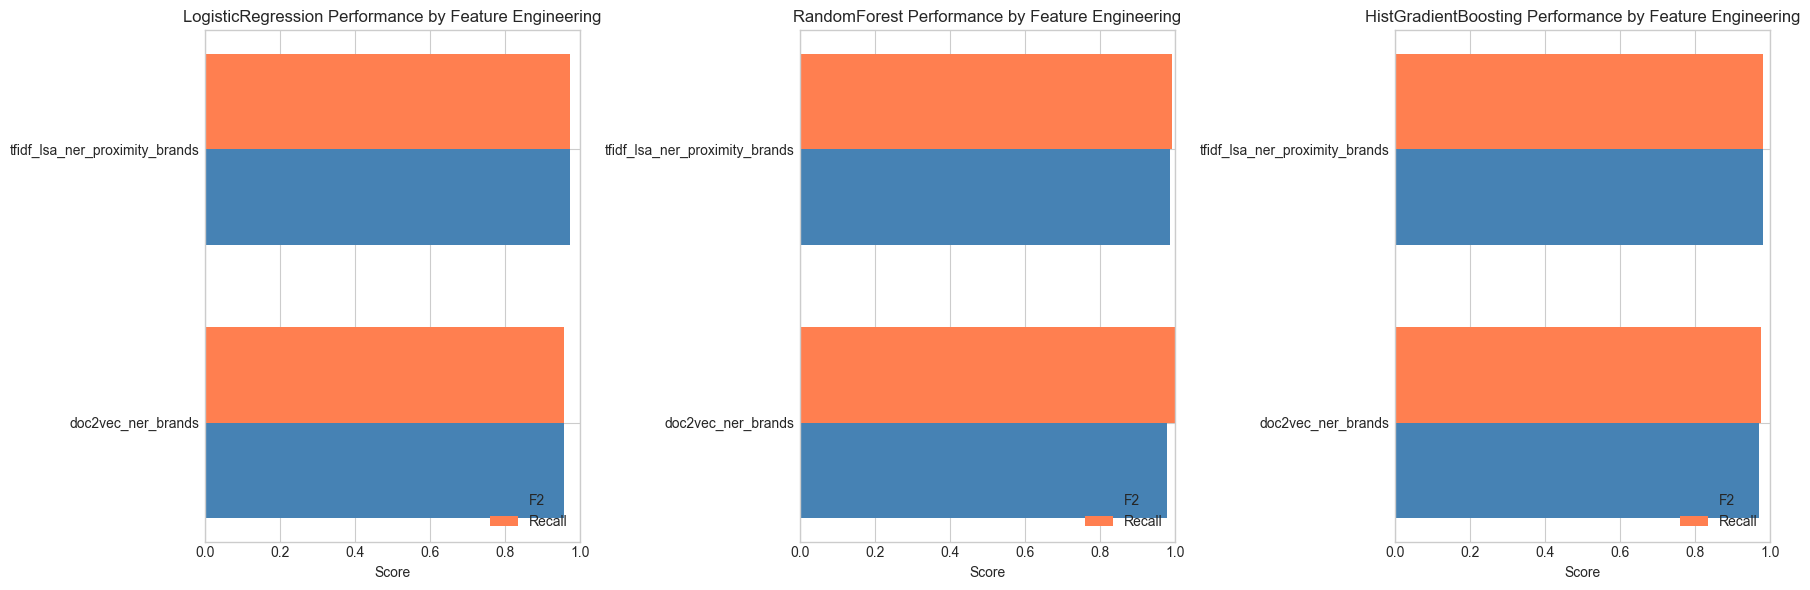

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method. Each method has a primary hyperparameter that affects its feature representation quality.

TUNING LSA_N_COMPONENTS FOR tfidf_lsa_ner_proximity_brands

Testing values: [70, 80, 90, 100, 120, 150, 200, 250, 300]
Classifier: RandomForest (baseline)
Transformer fitted on: TRAINING data only (921 samples)
CV evaluated on: TRAIN+VAL combined (1228 samples)
CV: 3-fold stratified

Testing lsa_n_components=70...
  CV F2: 0.9809 (+/- 0.0083)
Testing lsa_n_components=80...
  CV F2: 0.9805 (+/- 0.0098)
Testing lsa_n_components=90...
  CV F2: 0.9825 (+/- 0.0064)
Testing lsa_n_components=100...
  CV F2: 0.9850 (+/- 0.0060)
Testing lsa_n_components=120...
  CV F2: 0.9830 (+/- 0.0041)
Testing lsa_n_components=150...
  CV F2: 0.9834 (+/- 0.0075)
Testing lsa_n_components=200...
  CV F2: 0.9830 (+/- 0.0050)
Testing lsa_n_components=250...
  CV F2: 0.9829 (+/- 0.0035)
Testing lsa_n_components=300...
  CV F2: 0.9790 (+/- 0.0044)

LSA_N_COMPONENTS TUNING RESULTS
 lsa_n_components    cv_f2  cv_f2_std  cv_recall  cv_precision
              100 0.985016   0.005966   0.990712      0.962895
          

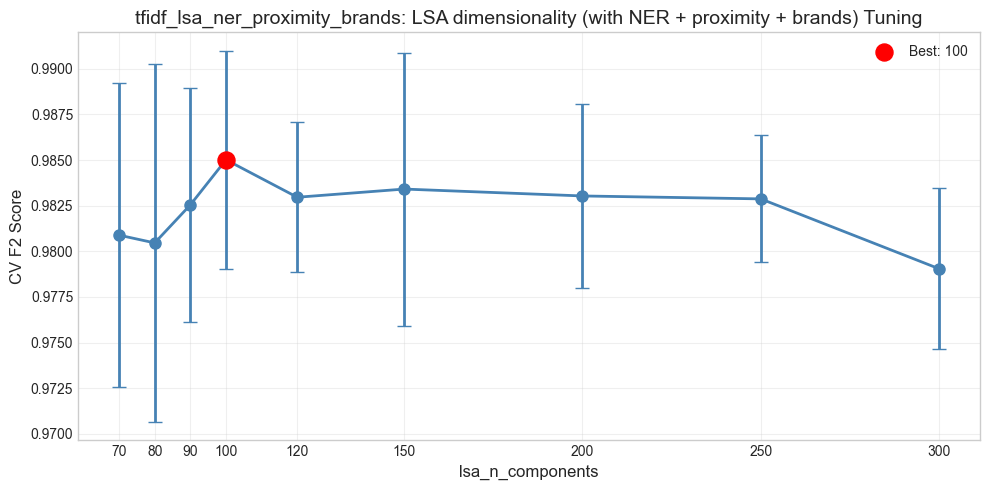

In [20]:
# Extract tuning configs from fe_configs for the tuning function
tuning_configs = {
    name: config['tuning']
    for name, config in fe_configs.items()
    if 'tuning' in config
}

# Run hyperparameter tuning for the best feature transformer
tuning_df, optimal_param_value, best_tuned_f2 = run_transformer_tuning(
    best_fe=best_fe,
    best_clf=best_clf,
    fe_configs=fe_configs,
    tuning_configs=tuning_configs,
    classifiers=classifiers,
    transformer_class=FPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    images_dir=IMAGES_DIR,
    train_source_names=train_source_names,
    train_categories=train_categories,
    trainval_source_names=trainval_source_names,
    trainval_categories=trainval_categories,
    random_state=RANDOM_STATE,
    n_folds=N_FOLDS,
)

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [21]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = {k: v for k, v in fe_configs[best_fe].items() if k != 'tuning'}
tuning_info = fe_configs[best_fe].get('tuning')
if tuning_info and optimal_param_value is not None:
    param_name = tuning_info['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration INCLUDING tuned hyperparameters
final_transformer = FPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on TRAINING data only to avoid data leakage
# (validation and test sets should only be transformed, never used for fitting)
X_train_final = final_transformer.fit_transform(
    X_train,
    source_names=train_source_names,
    categories=train_categories
)
print(f"\nFinal feature shape: {X_train_final.shape}")
print(f"Metadata features enabled: {final_transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {final_transformer._metadata_scaler is not None}")

# Verify transformer works on validation data
X_val_final = final_transformer.transform(
    X_val,
    source_names=val_source_names,
    categories=val_categories
)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: tfidf_lsa_ner_proximity_brands
Base configuration: {'method': 'tfidf_lsa_ner_proximity_brands', 'max_features': 10000, 'lsa_n_components': 100, 'proximity_window_size': 15, 'tuning': {'param_name': 'lsa_n_components', 'param_values': [70, 80, 90, 100, 120, 150, 200, 250, 300], 'description': 'LSA dimensionality (with NER + proximity + brands)'}}
Optimal lsa_n_components: 100

Final feature shape: (921, 193)
Metadata features enabled: True
Metadata scaler fitted: True
Validation feature shape: (307, 193)


In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [23]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Train+Val (used for CV): {len(X_trainval)} ({len(X_trainval)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")

# Report best results - use tuned values if tuning was performed
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")

# Use tuned score and feature count if tuning was done, otherwise use baseline
tuning_info = fe_configs[best_fe].get('tuning')
if tuning_info and optimal_param_value is not None:
    param_name = tuning_info['param_name']
    print(f"  - CV F2 Score: {best_tuned_f2:.4f} (after tuning)")
    print(f"  - Features: {X_train_final.shape[1]}")
    print(f"  - Optimal {param_name}: {optimal_param_value}")
else:
    print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
    print(f"  - Features: {int(best_row['n_features'])}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'} (fitted on training data only)")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 1535 articles
  - Training: 921 (60.0%)
  - Validation: 307 (20.0%)
  - Train+Val (used for CV): 1228 (80.0%)

Class distribution (training):
  - Sportswear: 727 (78.9%)
  - False Positive: 194 (21.1%)

Best Feature Engineering: tfidf_lsa_ner_proximity_brands
  - Best Classifier: RandomForest
  - CV F2 Score: 0.9850 (after tuning)
  - Features: 193
  - Optimal lsa_n_components: 100

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib (fitted on training data only)
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
